# Basic models and applications for strongly driven Josephson-junction (JJ) based resonant circuits

This notebook contains three sections: (1) provides the base model that shows the effects of driving an non-linear tank circuit, i.e., an LCR with a JJ used as a non-linear inductor. Using this insight, the following sections aims to explain (2) the inner workings of Josephson parametric amplifiers and (3) how the system can be tuned to a bifurcation regime, where it can be used as a digital discriminator.  

Models in sections 1 and 2 are taken from [Eichler, C., Wallraff, A. Controlling the dynamic range of a Josephson parametric amplifier. EPJ Quantum Technol. 1, 2 (2014)](https://doi.org/10.1140/epjqt2)

Theory in section 3 is adapted from [Vijay R., Devoret M. H. , Siddiqi I. The Josephson bifurcation amplifier. Rev. Sci. Instrum. 80, 111101 (2009)](https://doi.org/10.1063/1.3224703)

## 1. Input-output relations for the JJ-based tank circuit

We start by recalling the Hamiltonian for the quantum harmonic oscillator $H_{LC} = \hbar \omega_0 A^\dagger A + \frac{1}{2}$, where $\omega_0$ is the resonance frequency and $A$ is the annihilation operator for photons in the resonator.
When we substitute the L for a JJ, we get an additional term that adds non-linearity to the system:

$H_{JJ-C} = \hbar \left( \omega_0 A^\dagger A + \frac{K}{2} \left( A^\dagger \right)^2 A^2 \right)$,

where $K$ is a known as the *Kerr nonlinearity* term, which describes the strength of the non-linear interaction.

Applying the input/output formalism, which is described in more detail in section 3.1 in the reference above, we can obtain the following equation of motion for the photon-field in the resonator:

$\dot{A} = -i \left( \omega_0 A + K A^\dagger A A \right) - \frac{\kappa + \gamma}{2} A + \sqrt{\kappa} A_\mathrm{in}(t) + \sqrt{\gamma} b_\mathrm{in}(t)$,

with the boundary condition

$A_\mathrm{out}(t) = \sqrt{\kappa} A(t) - A_\mathrm{in}(t)$,

where $\kappa$ describes the coupling to a transmission line used to probe the circuit (i.e. line to tank circuit matching; related to the coupling Q), and $\gamma$ is the loss rate to environment modes $b_\mathrm{in}(t)$ (i.e. an R term in the circuit causing dissipation; related to the internal Q).

We want to first consider the effects of driving the JJ resonator with a strong drive, which replaces $A(t)$ with a classical wave $\alpha = | \alpha | e^{-i \omega_p t}$.

Following the procedure from the reference above, we obtain the following expression, which allows us to calculate the average number of pump photons stored in the resonator relative to the average number of input photons $n \equiv \frac{| \alpha |^2}{| \alpha_\mathrm{in} |^2}$:

$1 = \left( \delta^2 + \frac{1}{4} \right) n - 2 \delta \xi n^2 + \xi^2 n^3$,

with the following scaled quantities:

$\delta \equiv \frac{\omega_p - \omega_0}{\kappa + \gamma}, \qquad \xi \equiv \frac{| \alpha |^2 K}{\kappa + \gamma}$

$\delta$ is the detuning (in units of bandwidth) between the pump and the tank circuit's resonance frequency and $\xi$ is proportional to both the amplitude of the input pump field and the Kerr nonlinearity. For the scope of this notebook, we consider $K = -1$ fixed and assume that a sweep of $\xi$ corresponds to a sweep of the pump amplitude (the values of $\xi$ are a bit abstract in this notebook, to relate them to more realistic values of pump amplitude, we need to find realistic values for $K$).

At this point we can start playing with code to see how the number of photons in the resonator varies when we sweep the detuning or the amplitude of the pump...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar


Let's start by defining a function that returns solutions for $n$, given $\delta$ and $\xi$:

In [2]:
def resonator_photons(delta, xi):
    n = np.roots([xi**2, 2*delta*xi, (delta**2+0.25), -1])
    return [n_i.real for n_i in n if np.isreal(n_i)]

def photons_delta(delta_sweep, xi_list):
    xi_map = {}
    for xi in xi_list:
        photons = []
        delta_plot = []
        for d in delta_sweep:
            n = resonator_photons(d, xi)
            photons.extend(n)
            delta_plot.extend([d] * len(n))        
        plt.plot(delta_plot, photons, 'o', label=f'$\\xi = {xi:0.2f}$')
        xi_map[xi] = (np.array(photons), np.array(delta_plot))
    plt.xlabel('Scaled detuning $\\delta$ [BW]')
    plt.ylabel('Photons in resonator $n$')
    plt.legend(title='Pump amplitude')
    plt.show()
    return xi_map

As a first test of our function let's plot the simplest case of no pump, where the resonator is populated by photons driven by vacuum fluctuations:

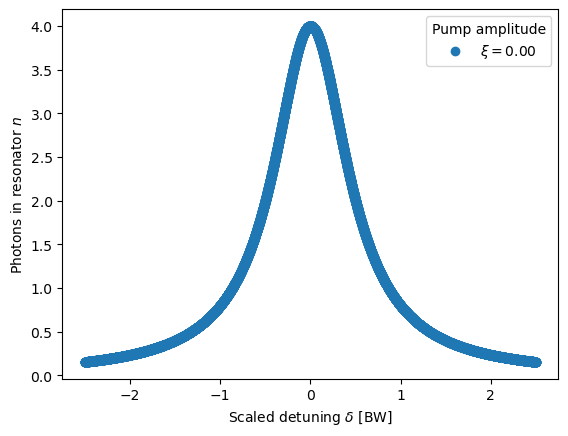

In [3]:
xi = [0]
delta_sweep = np.linspace(-2.5, 2.5, 10000)
_ = photons_delta(delta_sweep, xi)

Let's start increasing the pump power, and see what happens as we cross the critical amplitude $\xi_\mathrm{crit} = 1/\sqrt{27} = 0.19$, described in the paper:

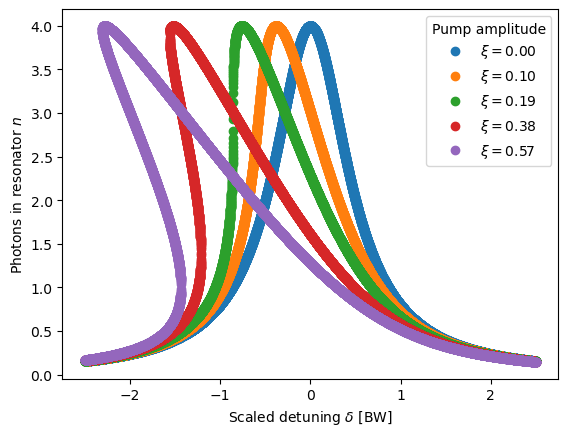

In [4]:
xi = np.array([0, 0.5, 1, 2, 3]) * 0.19
delta_sweep = np.linspace(-2.5, 2.5, 10000)
photons_xi = photons_delta(delta_sweep, xi)

At the pump amplitude that satisfies $\xi = \xi_\mathrm{crit}$ the photon number just before $\delta = -\sqrt{3}/2 = 0.87$ becomes extremely sensitive to changes in either detuning or amplitude, we will show how that condition can be used for linear amplification in section 2.

Past that point, the system bifurcates, having three solutions at a single frequency, two of which--the highest and lowest photon numbers--are stable. In section 3, we will see how this bistable condition can be used for qubit readout.

## 2. The JPA

We have so far looked at the effects of the pump on the number of photons stored in the resonator. To analyse a more measurable quantity, the reference derives an expression for the reflection coefficient of the nonlinear tank circuit:

$\Gamma = \frac{\alpha_\mathrm{out}}{\alpha_\mathrm{in}} = \frac{\kappa}{\kappa + \gamma} \frac{1}{\frac{1}{2} - i \left( \delta + \xi n \right)} - 1$

By plotting the magnitude and phase we can simulate what we would see in the $S_{11}$ of a reflectometry measurement on the circuit. Let's set that up:

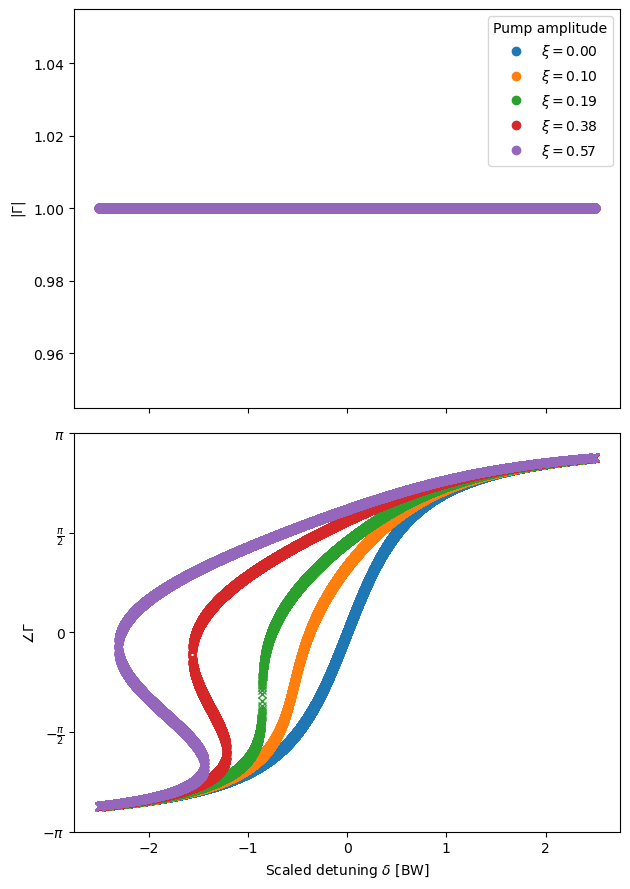

In [5]:
def pump_reflection(n, delta, kappa, gamma, xi):    
    reflection = kappa/(kappa+gamma) / (0.5 - (delta + xi*n)*1j) - 1
    return np.abs(reflection), np.angle(reflection) / np.pi

gamma = 0
kappa = 1 - gamma
fig, axs = plt.subplots(2, 1, figsize=(6.4, 9), sharex=True)
for xi, (n, delta) in photons_xi.items():
    mag, phase = pump_reflection(n, delta, kappa, gamma, xi)
    axs[0].plot(delta, mag, 'o', label=f'$\\xi = {xi:0.2f}$')
    axs[0].set_ylabel('$|\\Gamma|$')
    axs[1].plot(delta, phase, 'x', label=f'$\\xi = {xi:0.2f}$')
    axs[1].set_ylabel('$\\angle \\Gamma$')
axs[1].set_xlabel('Scaled detuning $\\delta$ [BW]')
axs[1].set_yticks(np.linspace(-1, 1, 5), ["$-\\pi$", "$-\\frac{\\pi}{2}$", "0", "$\\frac{\\pi}{2}$", "$\\pi$"])
axs[0].legend(title='Pump amplitude')
plt.tight_layout()

We initially set the the internal loss parameter $\gamma$ to zero ($Q_\mathrm{int} = \infty$), which is why the magnitude shows full reflection across the spectrum. Play around with that value to see the effects.

To understand how we can use this device as a linear amplifier, let's focus on the parameter space just before critical point. I will also now plot the amplitude dependence, at a fixed detuning:

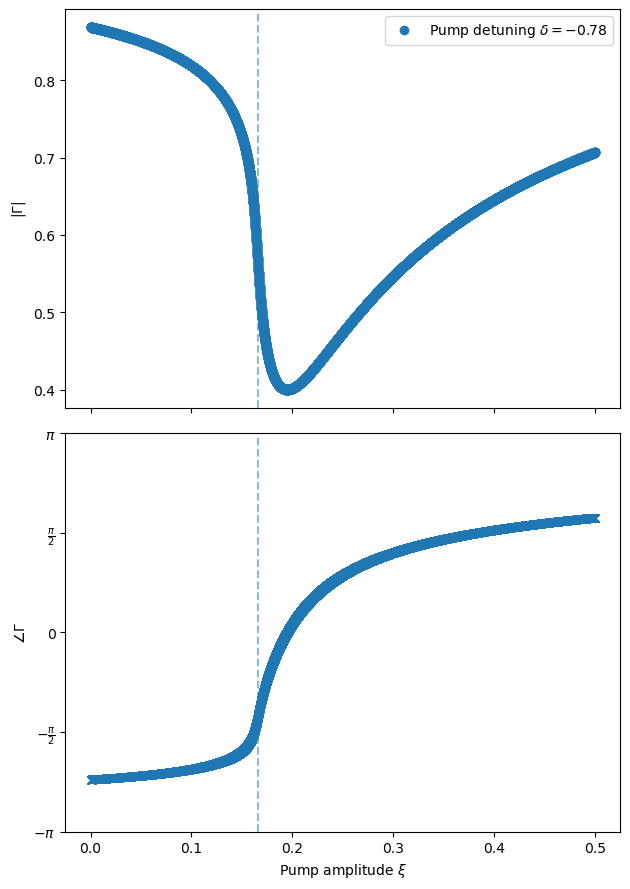

In [6]:
delta = -np.sqrt(3)/2 * 0.9
gamma = 0.3
kappa = 1 - gamma

def amp_response(xi_sweep, delta, gamma, kappa):
    photons = []
    xi_plot = []
    for xi in xi_sweep:
        n = resonator_photons(delta, xi)
        photons.extend(n)
        xi_plot.extend([xi] * len(n))
    mag, phase = pump_reflection(np.array(photons), np.array(delta), kappa, gamma, xi_plot)
    return np.array(xi_plot), mag, phase

xi_sweep = np.linspace(0, 0.5, 10000)
xi_plot, mag, phase = amp_response(xi_sweep, delta, gamma, kappa)
xi_steep = xi_plot[np.argmax(np.gradient(phase))]

def plot_amp_response(mag,phase, label=None, vlines=None, axs=None):
    if axs is None:
        fig, axs = plt.subplots(2, 1, figsize=(6.4, 9), sharex=True)
    line = axs[0].plot(xi_plot, mag, 'o', label=label)
    axs[0].set_ylabel('$|\\Gamma|$')
    if label is not None:
        axs[0].legend()
    axs[1].plot(xi_plot, phase, 'x')
    axs[1].set_ylabel('$\\angle \\Gamma$')
    axs[1].set_xlabel('Pump amplitude $\\xi$')
    axs[1].set_yticks(np.linspace(-1, 1, 5), ["$-\\pi$", "$-\\frac{\\pi}{2}$", "0", "$\\frac{\\pi}{2}$", "$\\pi$"])
    if vlines is not None:
        styles = ['--', ':', '.-']
        for i, vl in enumerate(vlines):
            axs[0].axvline(vl, linestyle=styles[i % len(styles)], alpha=0.5, color=line[0].get_color())
            axs[1].axvline(vl, linestyle=styles[i % len(styles)], alpha=0.5, color=line[0].get_color())
    plt.tight_layout()
    return axs

_ = plot_amp_response(mag, phase, label=f'Pump detuning $\\delta = {delta:0.2f}$', vlines=[xi_steep])


Close to the critical detuning, the nonlinearity produces a region (marked with dashed line) where both the magnitude and phase of the reflectometry response become extremely sensitive to the amplitude of the incoming signal. When we set the pump amplitude and frequency to this sensitive operating point, an additional signal coming from our quantum device will modulate these magnitude and phase parameters, allowing us to extract an amplified version of the device signal by demodulating the signal reflected from the JPA.

Because this JPA is embedded in a resonant circuit, the bandwidth of the input signal that can be amplified is quite narrow. To obtain a broader bandwidth amplifier, we can substitute the single nonlinear LC circuit by a chain nonlinear LCs, effectively converting the resonant circuit into a transmission line which can carry a broader bandwidth and that will gradually amplify the signal as it travels through. This is the basic principle of the Josephson travelling wave parametric amplifier (JTWPA), which we will not cover in detail here but you can read more about in:

[Yaakobi, et.al., Parametric amplification in Josephson junction embedded transmission lines, PRB (2013)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.87.144301)

[O'Brien, et. al., Resonant Phase Matching of Josephson Junction Traveling Wave Parametric Amplifiers, PRL (2014)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.157001)

## 3. Bifurcation amplifiers for qubit readout

By tuning the circuit's amplitude and frequency deep into the bifurcation regime, we can use it as a "digital discriminator". Let's plot the reflected response as a function of pump amplitude in this regime:

Text(0.9, 0.7, '$\\leftarrow |1\\rangle$')

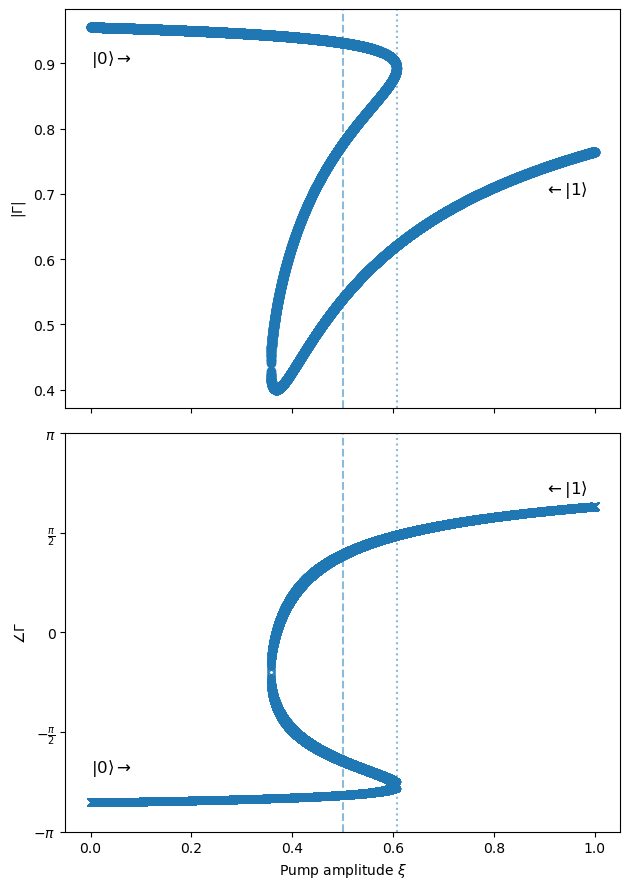

In [7]:
delta = -np.sqrt(3)/2 * 1.7
xi_sweep = np.linspace(0, 1, 10000)
xi_plot, mag, phase = amp_response(xi_sweep, delta, gamma, kappa)

# Find the bifurcation point (see markdown text below for explanation)
def bifurcation_point(xi_plot):
    solutions = 1
    i = 0
    while i < len(xi_plot)-2:
        if xi_plot[i] == xi_plot[i+1]:
            if xi_plot[i] == xi_plot[i+2]:
                solutions = 3
            else:
                solutions = 2
        else:
            if solutions < 2:
                solutions = 1
            else:
                return xi_plot[i]
        i += solutions
    return None

xi_b = bifurcation_point(xi_plot)    
axs = plot_amp_response(mag, phase, vlines=[0.5, xi_b])
axs[0].text(0.0, 0.9, r'$|0\rangle \rightarrow$', fontsize=12)
axs[0].text(0.9, 0.7, r'$\leftarrow |1\rangle$', fontsize=12)
axs[1].text(0.0, -0.7, r'$|0\rangle \rightarrow$', fontsize=12)
axs[1].text(0.9, 0.7, r'$\leftarrow |1\rangle$', fontsize=12)

At the point marked with the dashed line, the reflected signal can be stable at 2 well-separated values in phase space. The value at which the signal will be observed depends on the direction from which the pump amplitude has been ramped, providing a hystheresis effect. For reasons that will become clear later, let's call the low and high amplitude branches $|0\rangle$ and $|1\rangle$ respectively, as illustrated in the plot. 

If the pump is ramped from low amplitude to close to the *bifurcation point* $\xi_\mathrm{B}$ of the $|0\rangle$ branch (dotted line), the signal can switch from $|0\rangle$ to $|1\rangle$ with small (e.g. thermal) fluctuations in the signal amplitude. Note that once it switches to the $|1\rangle$ branch, it will *latch* and remain stable there, since it will be far away from the $|1\rangle$ bifurcation point.

Following the idea of the "$S$-curve" introduced in [Rev. Sci. Instrum. 80, 111101 (2009)](https://doi.org/10.1063/1.3224703) (see paragraphs around equation 11) we can zoom into the $|0\rangle$ bifurcation point and plot the $|0\rangle \to |1\rangle$ switch probability for some finite temperature $T$, given by

$P_{0 \to 1} = 1 - \exp{\left(- \tau_\mathrm{w} \tilde{\Gamma}_{01} (\xi) \right)}$

where $\tau_\mathrm{w}$ is the wait time scaled by the bandwidth, and the transition rate is

$\tilde{\Gamma}_{0 \to 1} \approx \delta^2 \left(1 - \left(\xi/\xi_\mathrm{B}\right)^2\right)^{1/2} \exp{\left(- \frac{|\delta|}{\tilde{\omega}_p \sqrt{\hbar}} \frac{\left(1 - \left(\xi/\xi_\mathrm{B}\right)^2\right)^{3/2}}{\coth{\left(1/\tilde{T}\right)}}\right)}$

where we define $\tilde{T} = \frac{2 k_\mathrm{B} T}{\hbar \omega_p}$ as the ratio of temperature to pump frequency and $\tilde{\omega}_p = \omega_p Q$ as the pump frequency scaled by the Q-factor of the tank circuit.

Notes to consider when playing with the code below: 
- These equations are very simplified versions of the equations in the reference, and the values used for the parameters in the plots below should only be considered for order-of-magnitude approximations
- If we make $\tau_w$ much smaller with respect to $\tilde{\omega}_p$, the $S$-curve breaks close to the bifurcation point, due to the simplifications used
- The equation only holds for $\xi \le \xi_\mathrm{B}$ (past this point you hopefully know what happens to the system :) )

Let's see what these $S$-curves look like:

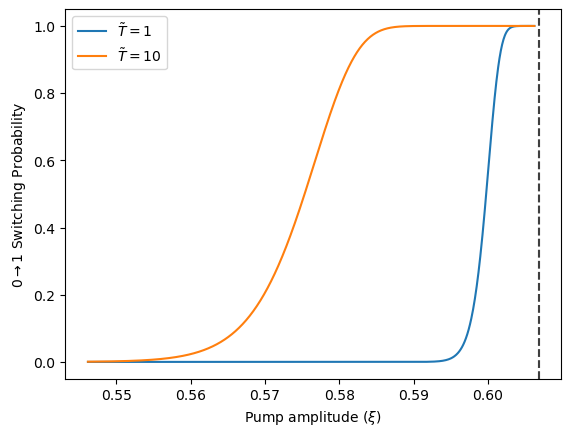

In [8]:
xi_zoom = np.linspace(0.9*xi_b, 0.999*xi_b, 1000)
t_w = 100 # wait_time * bandwidth
w_p = 1e14 # \omega_p * Q
temps = [1, 10] # ratio of temperature to pump frequency

def switching_probability(xi_zoom, xi_b, delta, t_w, w_p, temp):
    Gamma = delta**2 * np.sqrt(1 - (xi_zoom/xi_b)**2)*np.exp(-np.abs(delta)/w_p/np.sqrt(hbar)*np.tanh(1/temp)*np.sqrt(1 - (xi_zoom/xi_b)**2)**3)
    p_switch = 1 - np.exp(-t_w*Gamma)
    return p_switch

def plot_switching_probability(p_switch, xi_zoom, xi_b, label=None):
    plt.plot(xi_zoom, p_switch, label=label)
    plt.axvline(xi_b, linestyle='--', alpha=0.5, color='k')
    plt.legend()
    plt.ylabel('$0 \\to 1$ Switching Probability')
    plt.xlabel('Pump amplitude ($\\xi$)')

for temp in temps:
    p_switch = switching_probability(xi_zoom, xi_b, delta, t_w, w_p, temp)
    plot_switching_probability(p_switch, xi_zoom, xi_b, label=f'$\\tilde{{T}} = {temp}$')

As we increase the amplitude towards the bifurcation point, the likelihood that we will observe a switch to the $|1\rangle$ branch increases. Since the switch is caused by thermal excitations, increasing the temperature can cause transitions farther away from the bifurcation point, and also broadens the $S$-curve.

### Dispersive readout

Now let us add a dispersive coupling $g$ between this tank circuit and a qubit-system, which induces a qubit-state dependent shift in the frequency response of the resonator. As a simple model for this, we will use two different detuning values for each qubit state such that $\delta_{|1\rangle} - \delta_{|0\rangle} = g$, remembering that here $g$ is in units of bandwidth:

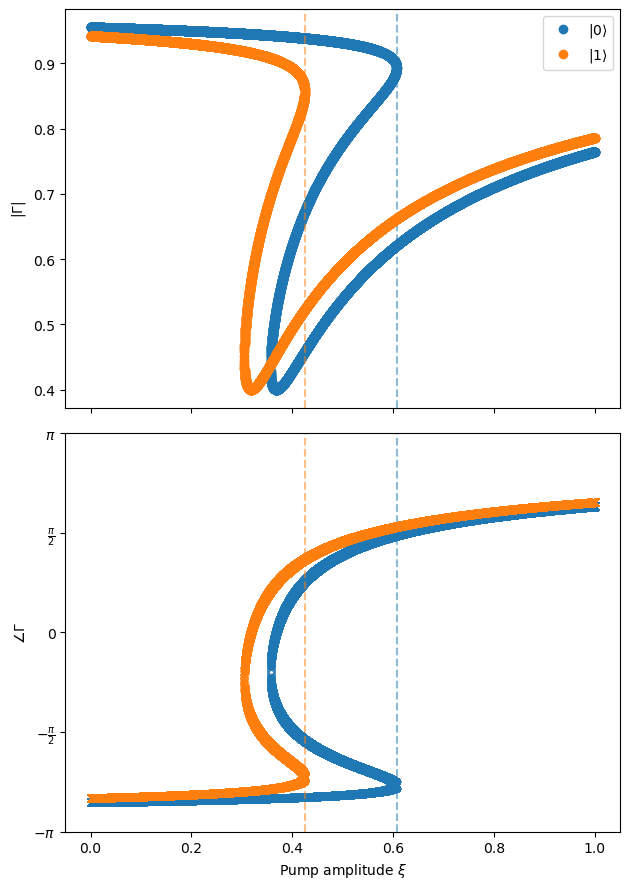

In [9]:
g = 0.2 # Coupling is g times the tank circuit bandwidth
deltas = [delta, delta + g]

xi_sweep = np.linspace(0, 1, 10000)
fig, axs = plt.subplots(2, 1, figsize=(6.4, 9), sharex=True)
xi_bs = []
for i,dq in enumerate(deltas):
    xi_plot, mag, phase = amp_response(xi_sweep, dq, gamma, kappa)
    xi_bs.append(bifurcation_point(xi_plot))
    axs = plot_amp_response(mag, phase, label=f"$|{i}\\rangle$", vlines=[xi_bs[-1]], axs=axs)


From these plots we can qualitatively see that if we ramp our tank circuit from zero, along the $|0\rangle$ branch and stop just above the orange dashed line, the reflected signal will be observed at two well-separated values in phase space, depending on the measured qubit state.

We can obtain a more quantitative assessment of the measurement fidelity by plotting the $S$-curves corresponding to each of the qubit states:

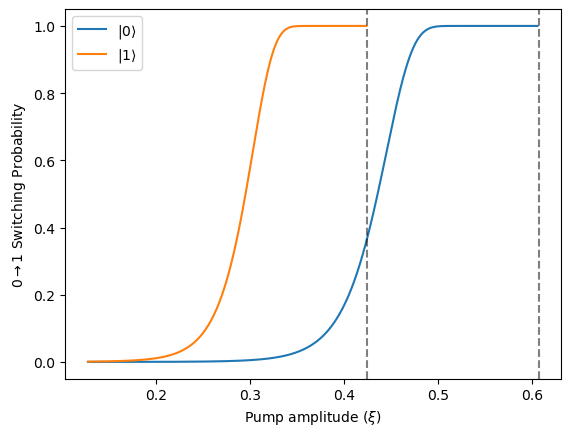

In [14]:
temp = 90 # ratio of temperature to pump frequency
p_switchs = []
for i, (xi_b,delta) in enumerate(zip(xi_bs, deltas)):
    xi_zoom = np.arange(0.3*min(xi_bs), 0.999*xi_b, 0.001)
    p_switchs.append(switching_probability(xi_zoom, xi_b, delta, t_w, w_p, temp))
    plot_switching_probability(p_switchs[-1], xi_zoom, xi_b, label=f'$|{{{i}}}\\rangle$')

# plt.axvline(xi_m, linestyle='--', alpha=0.5, color='C0', label=f'$\\xi_\\mathrm{{M}}$ fidelity: {max(fidelity):0.2f}')

To obtain the optimal pump amplitude $\xi_\mathrm{M}$ to ramp for measurement, we can plot the switching fidelity defined as the difference between the switching probabilities for each state (after you run the cell below, you can uncomment the last line in the cell above to see where $\xi_\mathrm{M}$ lies in the $S$-curve plot):

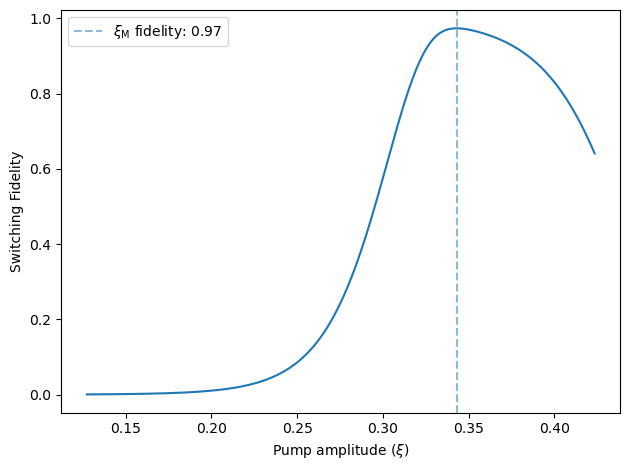

In [12]:
fidelity = p_switchs[1] - p_switchs[0][:len(p_switchs[1])]
xi_m = xi_zoom[np.argmax(fidelity)]
plt.plot(xi_zoom, fidelity)
plt.axvline(xi_m, linestyle='--', alpha=0.5, color='C0', label=f'$\\xi_\\mathrm{{M}}$ fidelity: {max(fidelity):0.2f}')
plt.legend()
plt.ylabel('Switching Fidelity')
plt.xlabel('Pump amplitude ($\\xi$)')
plt.tight_layout()

### Measurement protocol

1. During qubit operation, keep the pump on the tank off, so we start in the $|0\rangle$ branch
2. At the start of the measurement, ramp the pump to $\xi_\mathrm{M} \rightarrow$ ramp speed needs to consider overshoot vs switching probability 
3. Hold pump at $\xi_\mathrm{M} \rightarrow$ long enough time $\gg 1/g$ for the transfer of info betwee qubit and tank circut
4. Measure the reflected signal $\rightarrow$ magnitude or phase measurements should already provide good separation between the states, but a full phase-space characterisation can optimise the discrimination threshold further

### How latching helps readout

With the use of linear amplifiers (e.g. JPAs) in qubit systems with short relaxation times (e.g. superconducting qubits), the optimal measurement time has an upper boundary, since a relaxation event ($|1\rangle \to |0\rangle$) during measurement will cause the measured signal to switch.
When using our tank circuit in bifurcation mode for readout, this issue is avoided because the circuit will remain latched on to the $|1\rangle$ branch even after a relaxation event.